In [56]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [57]:
from bliss import sleep
from bliss.datasets import simulated

In [58]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [59]:
%matplotlib inline

# Load configs and starnet model

In [60]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [61]:
with initialize(config_path="../../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [62]:
cfg.model.decoder.kwargs.update({'n_bands': 1, 
                             'slen': 300, 
                             'tile_slen': 10, 
                             'ptile_slen': 30, 
                             'border_padding': 5, 
                             'mean_sources': 0.5,
                             'background_values': [680], 
                             'psf_params_file': './psf/zband_psf_fitted.npy'})

cfg.model.encoder.kwargs.update({'ptile_slen': 20})

cfg.dataset.kwargs.update({'n_batches': 1, 'batch_size': 1})


In [63]:
model_filename = './fits/starnet_decaps_z'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [64]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [65]:
border_padding = sleep_net.image_encoder.border_padding

# load data

In [74]:
from astropy.io import fits
hdul = fits.open('../../../../decaps/data/decaps_l0_b0_hdu08_z')

image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

slen = 300
x0 = 20
x1 = 20

In [75]:
# dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)
# out = dataset.get_batch()
# image = out['images']

# slen = 300
# x0 = border_padding
# x1 = border_padding

In [76]:
test_image = plotting.crop_image(image, 
                                 x0 - border_padding, 
                                 x1 - border_padding,
                                 slen + 2 * border_padding,
                                 slen + 2 * border_padding)

In [77]:
test_image.shape

torch.Size([1, 1, 310, 310])

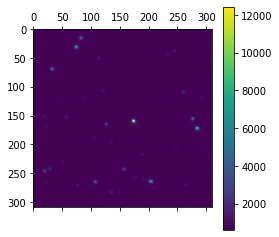

In [78]:
plt.matshow(test_image.cpu().numpy()[0, 0])
plt.colorbar()

In [103]:
torch.median(test_image[0, 0, 0:300:20, 0:300:20])

tensor(668.6873)

In [101]:
test_image[0, 0, 0, 50]

tensor(647.4814)

# Get starnet map estimates

In [79]:
map_estimate = sleep_net.image_encoder.map_estimate(test_image.to(device), slen)


# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

(array([14.,  5.,  9., 11., 11.,  5.,  2.,  6.,  1.,  3.]),
 array([3.077024 , 3.3079033, 3.5387828, 3.7696621, 4.0005417, 4.231421 ,
        4.4623003, 4.6931796, 4.9240594, 5.1549387, 5.385818 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

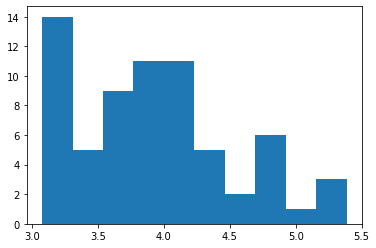

In [88]:
plt.hist(np.log10(map_estimate['fluxes'].squeeze().numpy()))

In [90]:
map_estimate['fluxes'].min()

tensor(1194.0537)

### Check the coverage

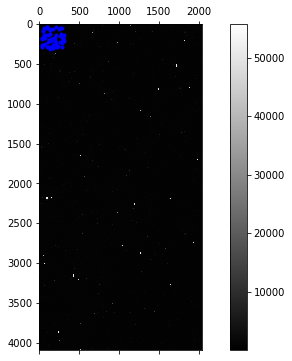

In [80]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='.',
        color='b', 
    )

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

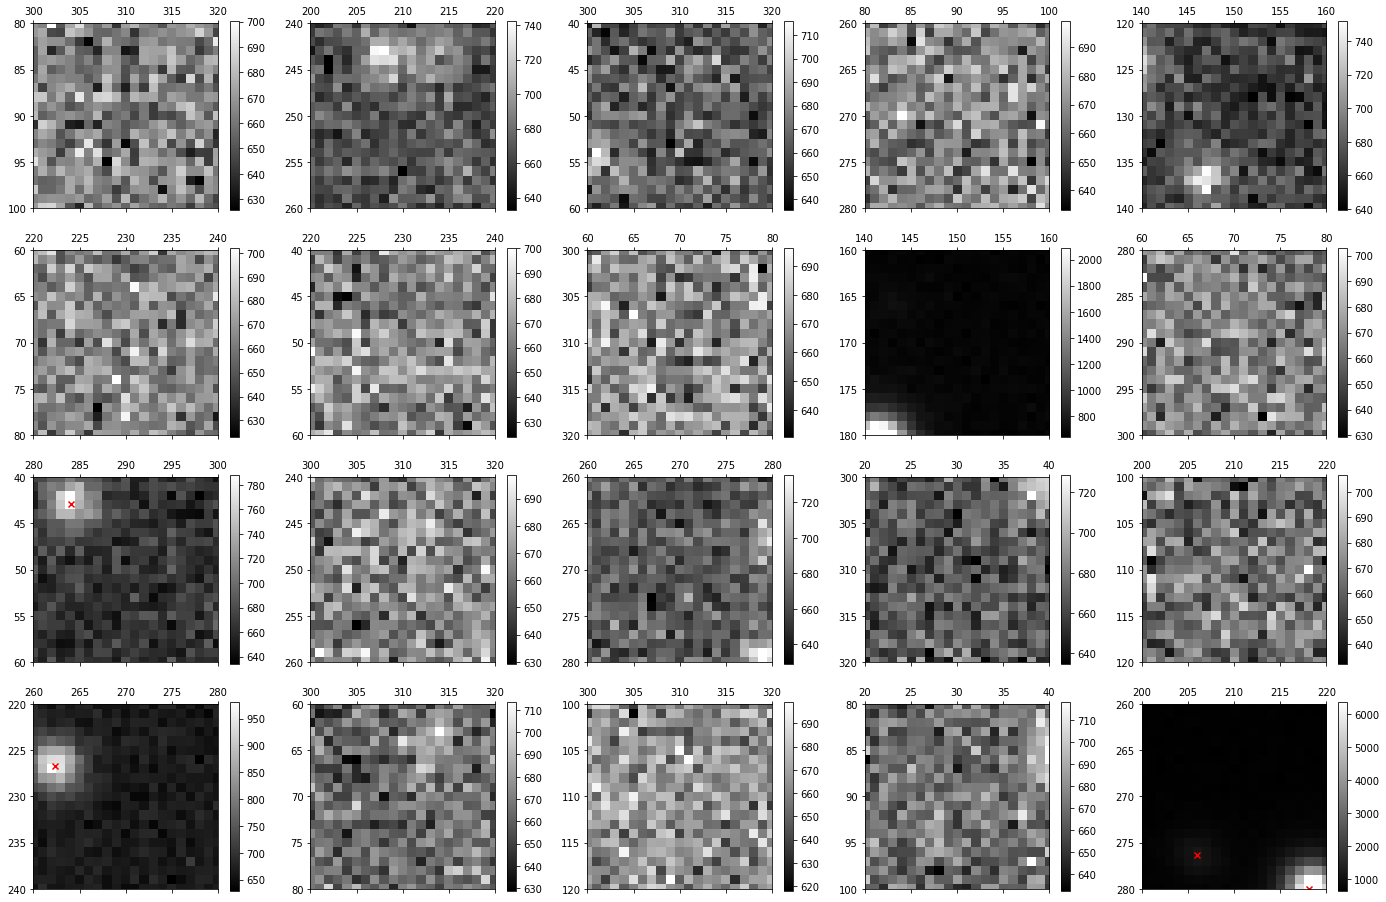

In [94]:
f, axarr = plt.subplots(4, 5, figsize=(24, 16))

subimage_slen = 20
x0_vec = np.arange(x0, x0 + slen, subimage_slen)
x1_vec = np.arange(x1, x1 + slen, subimage_slen)

for i in range(20): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)